# Interactions - Lab

## Introduction

In this lab, you'll explore interactions in the Ames Housing dataset.

## Objectives

You will be able to:
- Implement interaction terms in Python using the `sklearn` and `statsmodels` packages 
- Interpret interaction variables in the context of a real-world problem 

## Build a baseline model 

You'll use a couple of built-in functions, which we imported for you below: 

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

If you still want to build a model in the end, you can do that, but this lab will just focus on finding meaningful insights in interactions and how they can improve $R^2$ values.

In [2]:
linreg = LinearRegression()

Create a baseline model which includes all the variables we selected from the Ames housing data set to predict the house prices. Then use 10-fold cross-validation and report the mean $R^2$ value as the baseline $R^2$.

In [3]:
ames = pd.read_csv('ames.csv')

continuous = ['LotArea', 'FirstFlrSF', 'GrLivArea', 'SalePrice']
categoricals = ['BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street', 'Neighborhood']

## code here

ames.columns = ames.columns.map(lambda x: x if x != '1stFlrSF' else 'FirstFlrSF')

logged = pd.DataFrame()
proc_cont = pd.DataFrame()

for col in continuous:
    logged[col] = ames[col].map(np.log)
    logmean = logged[col].mean()
    logstd = logged[col].std()
    proc_cont[col+'_logstand'] = logged[col].map(lambda x: (x-logmean)/logstd)
    
proc_cat = pd.get_dummies(ames[categoricals], prefix = categoricals, drop_first = True)

proc = pd.concat([proc_cont, proc_cat], axis = 1)

X = proc.drop('SalePrice_logstand', axis = 1)
y = proc['SalePrice_logstand']

crossval = KFold(n_splits = 10, shuffle = True)
baseline = np.mean(cross_val_score(linreg, X, y, scoring = 'r2', cv = crossval))
baseline

0.8214590626316834

## See how interactions improve your baseline

Next, create all possible combinations of interactions, loop over them and add them to the baseline model one by one to see how they affect the $R^2$. We'll look at the 3 interactions which have the biggest effect on our $R^2$, so print out the top 3 combinations.

You will create a `for` loop to loop through all the combinations of 2 predictors. You can use `combinations` from itertools to create a list of all the pairwise combinations. To find more info on how this is done, have a look [here](https://docs.python.org/2/library/itertools.html).

Since there are so many different neighbourhoods we will exclude

In [4]:
from itertools import combinations

In [5]:
# code to find top interactions by R^2 value here
combos = list(combinations(X.columns, 2))
best_inters = pd.Series(index = [a+'*'+b for a, b in combos], dtype = 'float64')
for combo in combos:
    a, b = combo
    df = X.copy()
    df[a+'*'+b] = X[a]*X[b]
    score = np.mean(cross_val_score(linreg, df, y, scoring = 'r2', cv = crossval))
    best_inters[a+'*'+b] = score
    
best_inters.sort_values(ascending = False).head()

Neighborhood_SWISU*Neighborhood_Timber    0.826091
MSZoning_RH*MSZoning_RL                   0.825693
SaleType_ConLw*Neighborhood_Timber        0.825596
KitchenQual_Fa*MSZoning_RH                0.825586
Street_Pave*Neighborhood_Edwards          0.825316
dtype: float64

In [6]:
# I disagree with the below. In their solution code, they didn't
# make a new copy of X each time. My R-squared values are higher
# than those in the solution code. For the following section,
# I will instead use LotArea_logstand*Neighborhood_NridgHt, with
# R-squared value 0.824

In [7]:
best_inters['LotArea_logstand*Neighborhood_NridgHt']

0.8195073133318834

It looks like the top interactions involve the Neighborhood_Edwards feature so lets add the interaction between LotArea and Edwards to our model.

We can interpret this feature as the relationship between LotArea and SalePrice when the house is in Edwards or not.

## Visualize the Interaction

Separate all houses that are located in Edwards and those that are not. Run a linear regression on each population against `SalePrice`. Visualize the regression line and data points with price on the y axis and LotArea on the x axis.

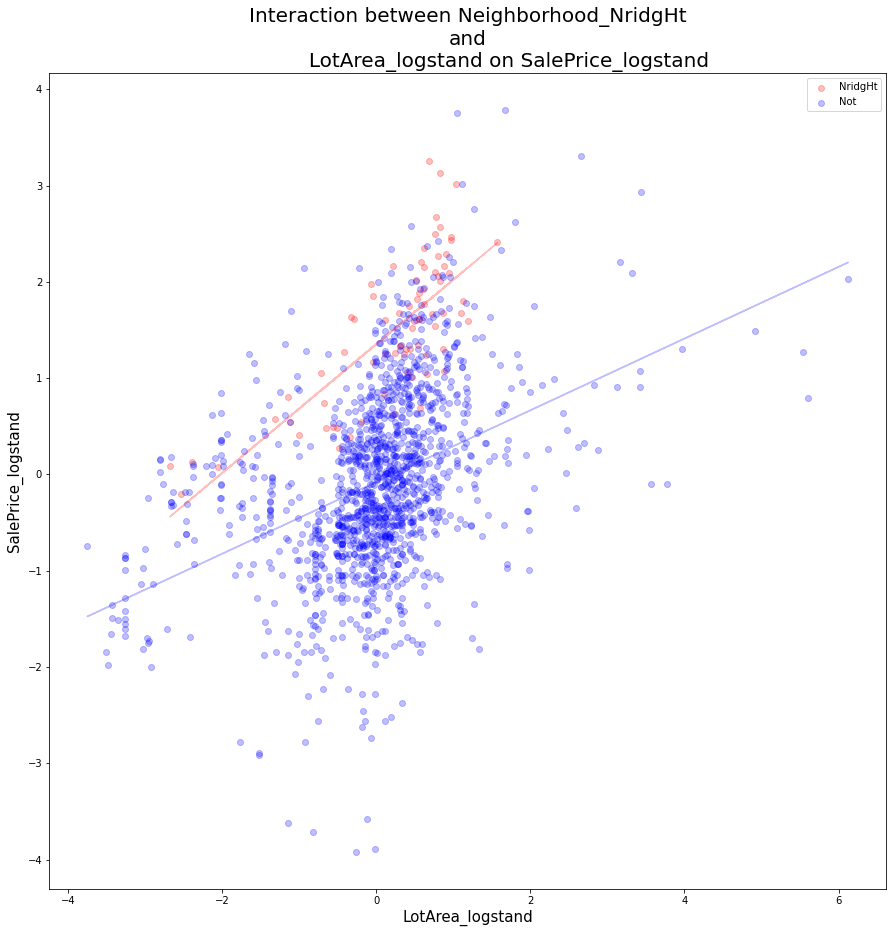

In [8]:
# Visualization code here
df_NridgHt = proc.loc[X['Neighborhood_NridgHt'] == 1]
X_NridgHt = df_NridgHt['LotArea_logstand']
y_NridgHt = df_NridgHt['SalePrice_logstand']

df_not = proc.loc[X['Neighborhood_NridgHt'] != 1]
X_not = df_not['LotArea_logstand']
y_not = df_not['SalePrice_logstand']

reg_NridgHt = LinearRegression().fit(np.array(X_NridgHt).reshape(-1,1), y_NridgHt)
reg_not = LinearRegression().fit(np.array(X_not).reshape(-1,1), y_not)

yhat_NridgHt = reg_NridgHt.predict(np.array(X_NridgHt).reshape(-1,1))
yhat_not = reg_not.predict(np.array(X_not).reshape(-1,1))

fig, ax = plt.subplots(figsize = (15,15))

ax.scatter(X_NridgHt, y_NridgHt, color = 'red', label = 'NridgHt', alpha = 0.25)
ax.plot(X_NridgHt, yhat_NridgHt, color = 'red', alpha = 0.25)
ax.scatter(X_not, y_not, color = 'blue', label = 'Not', alpha = 0.25)
ax.plot(X_not, yhat_not, color = 'blue', alpha = 0.25)
ax.set_title('''Interaction between Neighborhood_NridgHt\nand
             LotArea_logstand on SalePrice_logstand''', fontsize = 20)
ax.set_xlabel('LotArea_logstand', fontsize = 15)
ax.set_ylabel('SalePrice_logstand', fontsize = 15)
plt.legend();

## Build a final model with interactions

Use 10-fold cross-validation to build a model using the above interaction. 

In [9]:
# code here
X['LotArea_logstand*Neighborhood_NridgHt'] = X['LotArea_logstand']*X['Neighborhood_NridgHt']

new_r2 = np.mean(cross_val_score(linreg, X, y, scoring = 'r2', cv = crossval))
new_r2

0.81988907081886

Our $R^2$ has increased considerably! Let's have a look in `statsmodels` to see if this interactions are significant.

In [10]:
# code here
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     SalePrice_logstand   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     154.5
Date:                Wed, 23 Jun 2021   Prob (F-statistic):               0.00
Time:                        16:26:12   Log-Likelihood:                -732.53
No. Observations:                1460   AIC:                             1563.
Df Residuals:                    1411   BIC:                             1822.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.2352      0.264     -0.890      0.373      -0.754       0.283
LotArea_logstand                          0.0994      0.019      5.279      0.000       0.062       0.136
FirstFlrSF_logstand                       0.1368      0.016      8.595      0.000       0.106       0.168
GrLivArea_logstand                        0.3774      0.016     24.234      0.000       0.347       0.408
BldgType_2fmCon                          -0.1705      0.079     -2.167      0.030      -0.325      -0.016
BldgType_Duplex                          -0.4171      0.061     -6.784      0.000      -0.538      -0.296
BldgType_Twnhs                           -0.0204      0.099     -0.205      0.837      -0.215       0.174
BldgType_TwnhsE                           0.0032      0.062      0.052      0.958      -0.118       0.124
KitchenQual_Fa                           -0.9772      0.088    -11.064      0.000      -1.150      -0.804
KitchenQual_Gd                           -0.3560      0.051     -7.033      0.000      -0.455      -0.257
KitchenQual_TA                           -0.6448      0.056    -11.604      0.000      -0.754      -0.536
SaleType_CWD                              0.2261      0.215      1.054      0.292      -0.195       0.647
SaleType_Con                              0.5812      0.303      1.918      0.055      -0.013       1.176
SaleType_ConLD                            0.3117      0.155      2.014      0.044       0.008       0.615
SaleType_ConLI                            0.0250      0.195      0.128      0.898      -0.357       0.407
SaleType_ConLw                            0.0554      0.195      0.284      0.777      -0.328       0.439
SaleType_New                              0.2950      0.079      3.753      0.000       0.141       0.449
SaleType_Oth                              0.1224      0.245      0.501      0.617      -0.357       0.602
SaleType_WD                               0.1788      0.065      2.747      0.006       0.051       0.307
MSZoning_FV                               1.0481      0.192      5.447      0.000       0.671       1.426
MSZoning_RH                               0.8953      0.194      4.621      0.000       0.515       1.275
MSZoning_RL                               1.0216      0.162      6.323      0.000       0.705       1.339
MSZoning_RM                               1.0983      0.151      7.263      0.000       0.802       1.395
Street_Pave                              -0.2175      0.180     -1.210      0.226      -0.570       0.135
Neighborhood_Blueste                      0.0378      0.317      0.119      0.905      -0.584       0.659
Neighborhood_BrDale                      -0.4947      0.170     -2.904      0.004      -0.829      -0.160
Neighborh

What is your conclusion here?

In [12]:
# formulate your conclusion
# The added column is defnitely significant, with p-value 0.001

## Summary

You should now understand how to include interaction effects in your model! As you can see, interactions can have a strong impact on linear regression models, and they should always be considered when you are constructing your models.